![](https://www.weenect.com/blog/wp-content/uploads/2018/07/accident-route-chien.jpg)

We work for CC: ConscientiousCars where we help self-driving vehicles be more conscientious of their surroundings. Our cars have been very good at recognizing and avoiding humans. They haven't, however, been capable of recognizing dogs. Since dogs are man's best friend and will always be where we humans are, we want our cars to know if a dog is on the road in front of them and avoid the dog. 

\\

The first step to avoiding these cute puppers is **knowing if a pupper is in front of the car**

\\

So, today, we will **build a detector that can tell when our car sees a dog or not**!


In [1]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()
  
def CNNClassifier(num_epochs=30, layers=5, dropout=0.5):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout / 2.0))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Understanding our data

Our cars are very attentive and always have their eyes on the road.

Every second, they're streaming in data about the street, including video.

From this video data, we want our car to tell: is there 'road' or 'dog' in front of it?

Lucky for us, we have a dataset of dog and road images already prepared! Let's start by reading that *labeled* data in. 


In [2]:
# load our data
data, labels = load_data()

label: dog


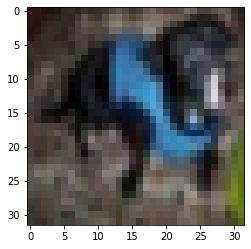

In [3]:
# let's look at our first image
plot_one_image(data, labels, 0)

label: road


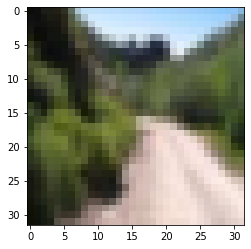

In [4]:
# let's look at an image of a road
plot_one_image(data, labels, 700)

How many dogs and roads do we have? 

In [5]:
label_counter = Counter(labels)
print(label_counter)
NUM_DOGS = label_counter['dog']
NUM_ROADS = label_counter['road']
print('Number of dogs: ', NUM_DOGS)
print('Number of roads: ', NUM_ROADS)

Counter({'dog': 600, 'road': 600})
Number of dogs:  600
Number of roads:  600


The dataset is organized such that the first 600 images are pictures of dogs and the last 600 images are pictures of roads.

###Exercise 1 ✍️

**Look at a few more images of both classes.**

As a challenge, try to code a for loop to look at 5 images!

label: road


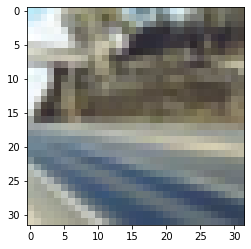

label: road


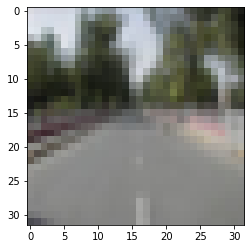

label: dog


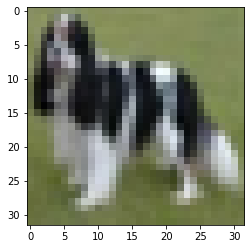

label: dog


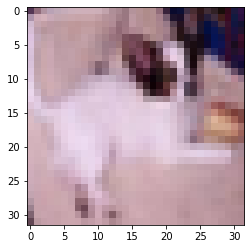

label: dog


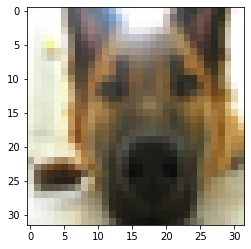

In [6]:
### YOUR CODE HERE
for i in range(5):
  b = np.random.randint(len(data))
  plot_one_image(data, labels, b)
### END CODE

Here, our images are stored as the color of each pixel in the image. 


In [7]:
print('One image looks like: ')
print(data[0])

One image looks like: 
[45 20 19 ... 83 99 31]


### Question 💡

**What do you think these numbers mean?**

Each of these numbers is a single **input**. 

In [8]:
print('Each image is 32 x 32 pixels where each pixel has 3 values for \nred green and blue')
print('Each image has 32 x 32 x 3 = %d inputs'%data[0].shape)

Each image is 32 x 32 pixels where each pixel has 3 values for 
red green and blue
Each image has 32 x 32 x 3 = 3072 inputs


We use these **inputs** to classify, or predict, what our image is. 

Our image's category is contained in `labels`. Labels is a list of all of our images' categories. Each label is either `dog` or `road`. 

In [9]:
print('Our labels list looks like:')
print(set(labels))

Our labels list looks like:
{'dog', 'road'}


## A simple machine learner




We want to create a machine learning *model* that can tell us whether a new image is either a `dog` or a `road`. 

We will give our *model* a *training manual* of data and labels that it will study or train on. 

We then check how well our model is doing on a *test*, where it is given data and told to predict their labels. 

Finally, we check  how our model did by giving it a *test*. The accuracy score tells us what percentage of test data it classified correctly. 100% means that all the images were classifered correctly.



###Exercise 2 ✍️


Build your own KNN model where you change the number of neighbors. Try to see how high you can make the accuracy go!! We want our pets to be safe after all. 

In [ ]:
### YOUR CODE HERE
from sklearn.model_selection import train_test_split
knn = KNeighborsClassifier()
inputs_train, inputs_test, labels_train, labels_test = train_test_split(data, labels)
knn.fit(inputs_train, labels_train)
labels_pred = knn.predict(inputs_test)
accuracy_score(labels_test, labels_pred)
### END CODE

0.8166666666666667

We can use our trained model to predict whether our car is seeing a `dog` or `road`. Let's try this out!

label: dog


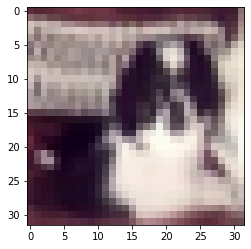

prediction: dog


In [ ]:
# Specify which image you want to show
image_id = 100

# Visualize the image
plot_one_image(inputs_test, labels_test, image_id)

# Use the model to predict what this might be and print it
print('prediction:', knn.predict([inputs_test[image_id]])[0])

### Exercise 3 ✍️

We do alright on the classification, but our classifier could do much better. Let's put on our detective hats to determine what the root cause of the incorrect classifications are.

**Print out 4 images of true positives, 4 images of true negatives, 4 images of false positives, and 4 images of false negatives. What are the reasons for failure (both for false positives and false negatives)? **

True positive:
label: dog


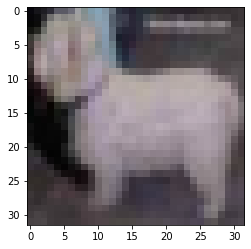

True negative:
label: road


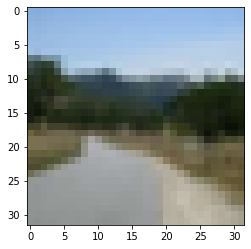

True negative:
label: road


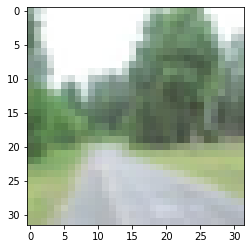

True positive:
label: dog


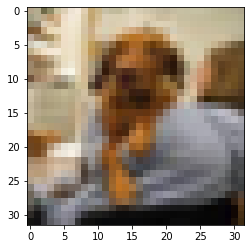

True positive:
label: dog


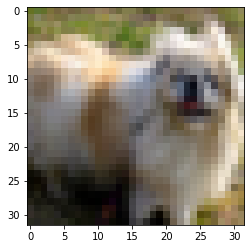

True negative:
label: road


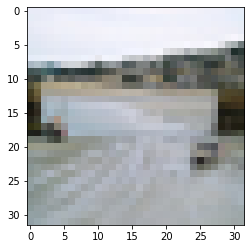

True negative:
label: road


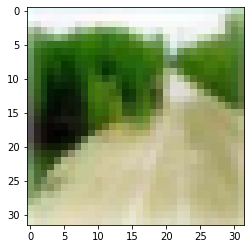

True negative:
label: road


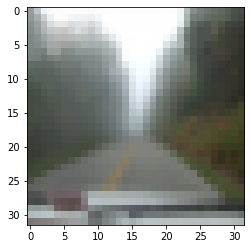

False negative:
label: dog


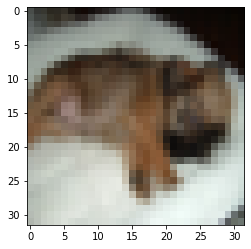

True negative:
label: road


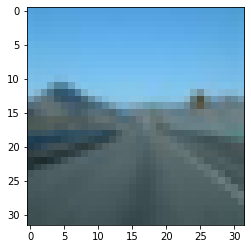

True positive:
label: dog


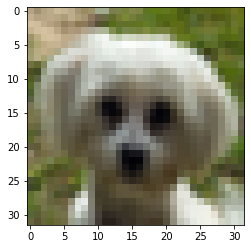

True positive:
label: dog


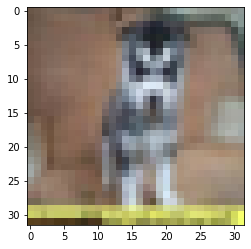

True negative:
label: road


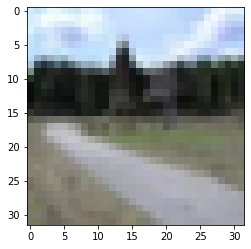

True positive:
label: dog


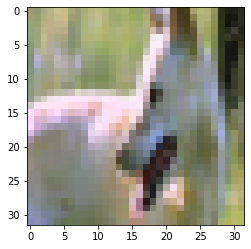

True negative:
label: road


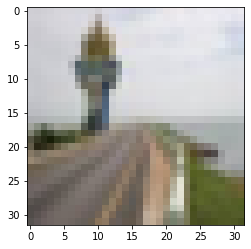

False negative:
label: dog


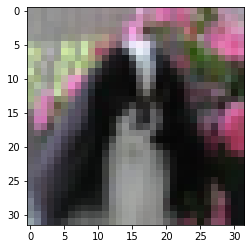

True positive:
label: dog


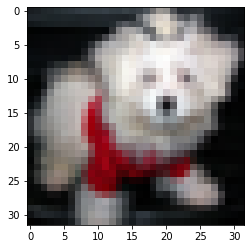

True positive:
label: dog


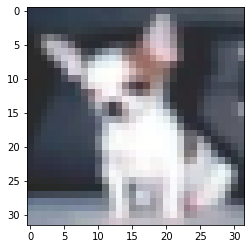

True positive:
label: dog


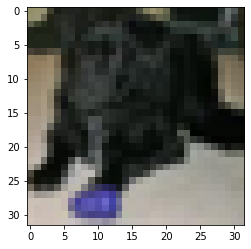

True negative:
label: road


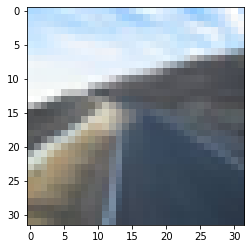

True negative:
label: road


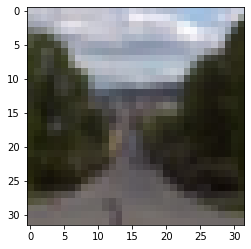

True negative:
label: road


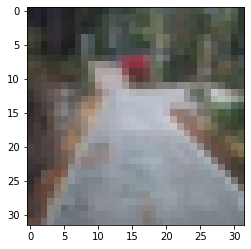

True negative:
label: road


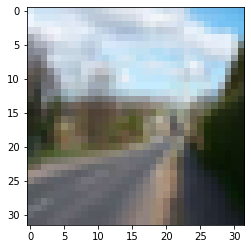

True negative:
label: road


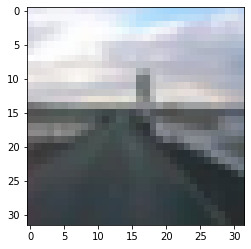

True negative:
label: road


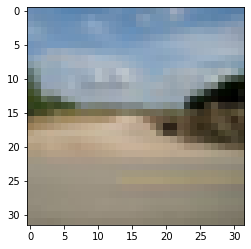

True negative:
label: road


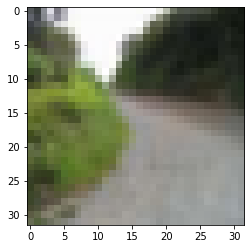

True negative:
label: road


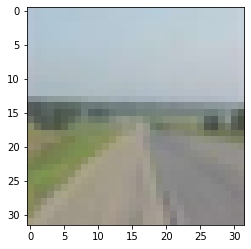

True negative:
label: road


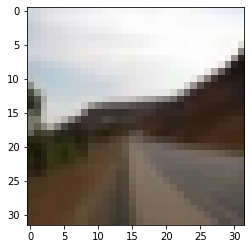

False negative:
label: dog


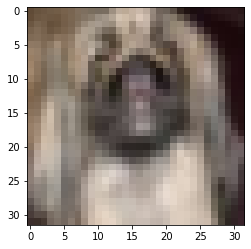

False negative:
label: dog


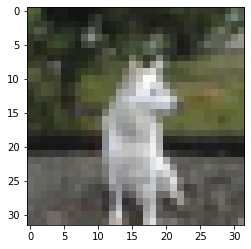

False negative:
label: dog


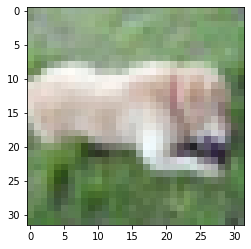

False negative:
label: dog


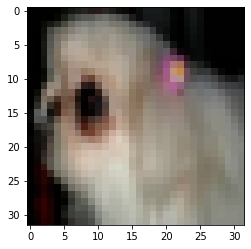

True positive:
label: dog


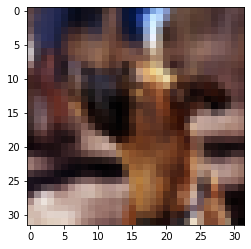

False negative:
label: dog


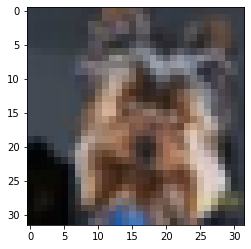

False negative:
label: dog


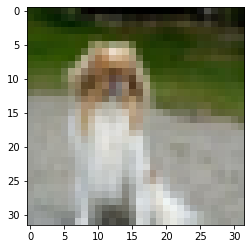

False negative:
label: dog


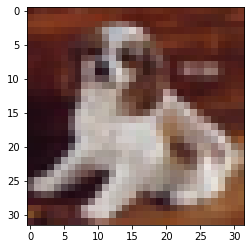

False negative:
label: dog


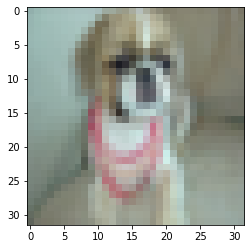

True negative:
label: road


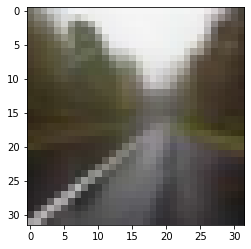

False negative:
label: dog


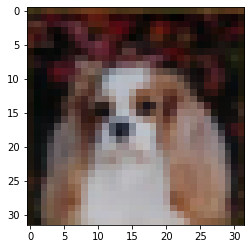

True positive:
label: dog


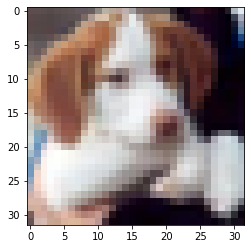

True positive:
label: dog


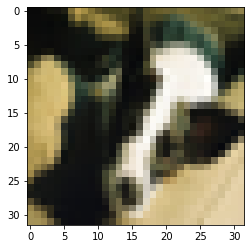

False negative:
label: dog


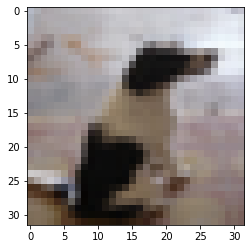

True negative:
label: road


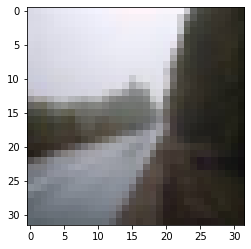

True positive:
label: dog


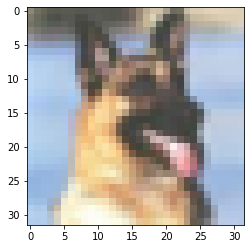

True negative:
label: road


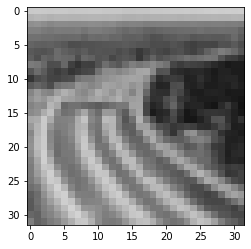

True positive:
label: dog


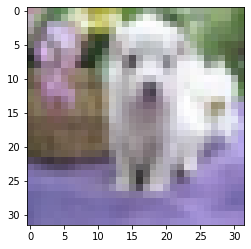

True positive:
label: dog


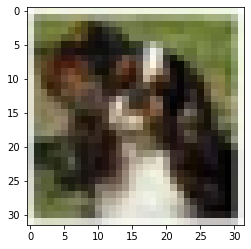

True positive:
label: dog


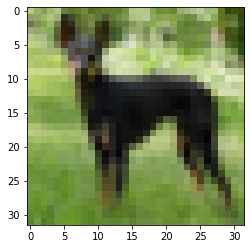

True negative:
label: road


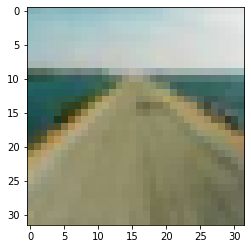

True negative:
label: road


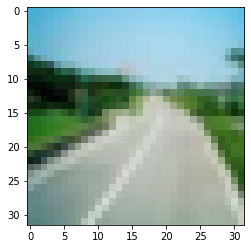

True negative:
label: road


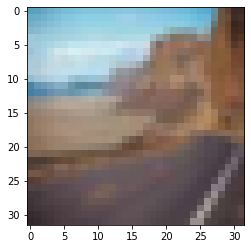

True positive:
label: dog


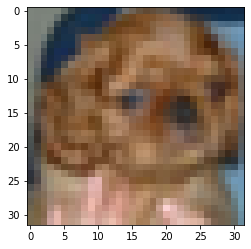

True negative:
label: road


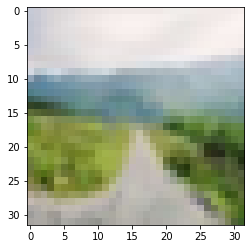

True negative:
label: road


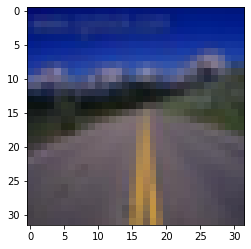

True positive:
label: dog


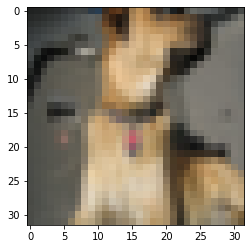

True negative:
label: road


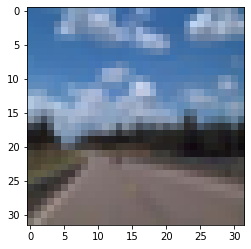

False negative:
label: dog


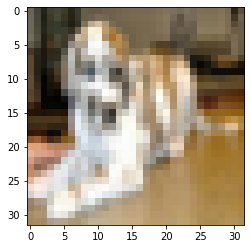

True positive:
label: dog


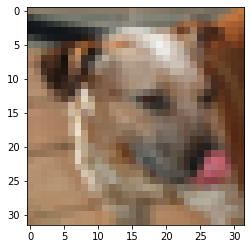

True negative:
label: road


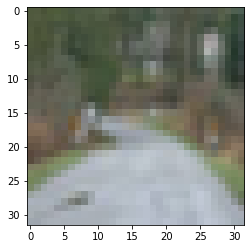

True negative:
label: road


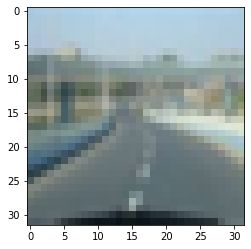

True negative:
label: road


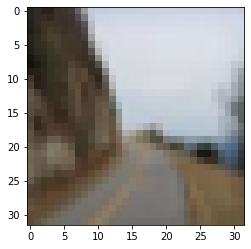

True negative:
label: road


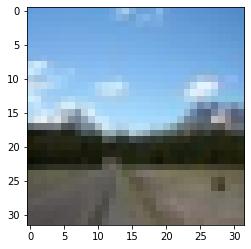

True positive:
label: dog


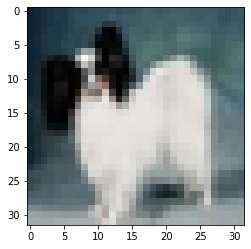

True negative:
label: road


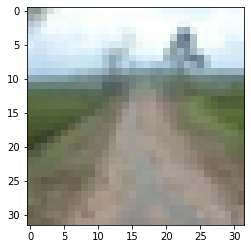

True negative:
label: road


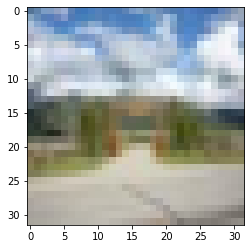

True negative:
label: road


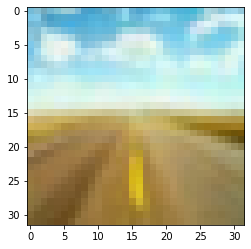

True positive:
label: dog


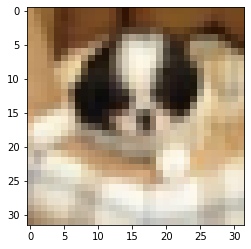

True negative:
label: road


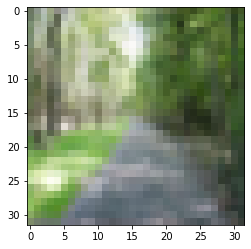

True positive:
label: dog


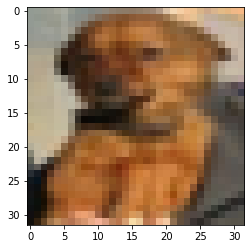

True negative:
label: road


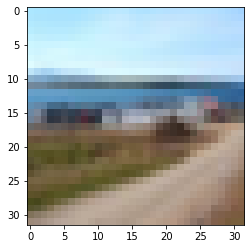

True positive:
label: dog


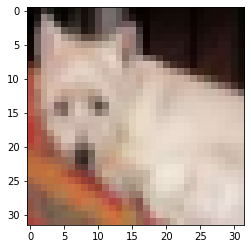

True positive:
label: dog


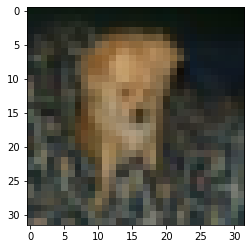

False negative:
label: dog


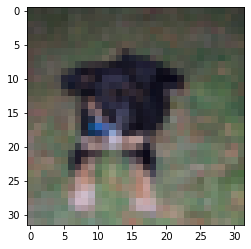

True negative:
label: road


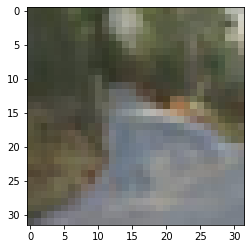

True positive:
label: dog


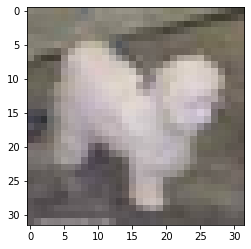

True positive:
label: dog


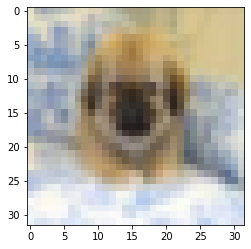

True negative:
label: road


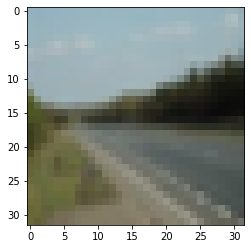

True negative:
label: road


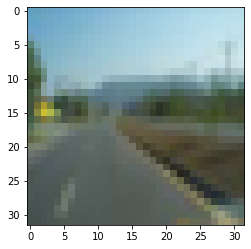

True negative:
label: road


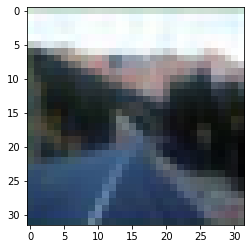

True positive:
label: dog


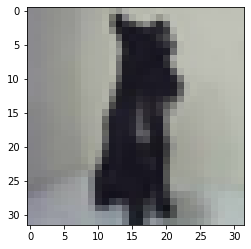

True negative:
label: road


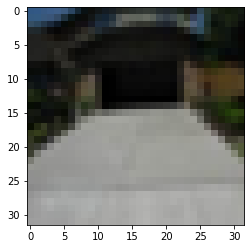

False positive:
label: road


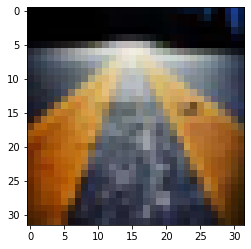

In [ ]:
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

for i in range(len(labels_test)):
  prediction = knn.predict([inputs_test[i]])# YOUR CODE HERE

  # True positive.
  if prediction == labels_test[i] and prediction == 'dog':
    print('True positive:')
    plot_one_image(inputs_test, labels_test, i)
    true_positives += 1
    
  # (Is this TN, FP, or FN?)
  elif prediction == labels_test[i] and prediction == 'road':
    print('True negative:')
    plot_one_image(inputs_test, labels_test, i)
    true_negatives += 1
  
  # (Is this TN, FP, or FN?)
  elif prediction != labels_test[i] and prediction == 'dog':
    print('False positive:')
    plot_one_image(inputs_test, labels_test, i)
    false_positives += 1
  
  # (Is this TN, FP, or FN?)
  elif prediction != labels_test[i] and prediction == 'road':
    print('False negative:')
    plot_one_image(inputs_test, labels_test, i)
    false_negatives += 1
  
  # Stop when we have at least 4 TP, TN, FP, and FN.
  if true_positives >= 1 and false_positives >= 1 and \
    true_negatives >= 1 and false_negatives >= 1:
    break

**What are the causes of false positives and false negatives?**

### Exercise 4 ✍️

Determine the optimal value of "K" for our data. Use a for-loop to loop through different values of "K". In particular, *at the very least* try K = 1, 3, 5, 10, 20, and 30. For each of these values of "K", define a new KNN model, train it, and evaluate the accuracy.

In [ ]:


### YOUR CODE HERE
for k in [1, 3, 5, 10, 20]:
  knn = KNeighborsClassifier(n_neighbors = k)

  knn.fit(inputs_train, labels_train)
  print("for " + str(k) + " : " + str(accuracy_score(labels_test, knn.predict(inputs_test))))


for 1 : 0.8033333333333333
for 3 : 0.8033333333333333
for 5 : 0.83
for 10 : 0.86
for 20 : 0.83


**What is the optimal value of "K"?**

## TENSORFLOW PLAYGROUND ACTIVITY (20 MINS) 

Open [this](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62283&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularization_hide=true&regularizationRate_hide=true&learningRate_hide=true&batchSize_hide=true&stepButton_hide=true&activation_hide=true) to understand Neural Networks!

## Using a simple neural network

Let's now try a neural network for this and see how well it does. 

To build a simple neural network, we use `MLPClassifier` from scikit-learn. We will play with the **number of neurons** and the **number of hidden layers** to adjust the complexity of our model! Just like we did in Playground. 

Let's see how well we can do. :) 

**Example 1:**

If we want to create a neural network with 1 hidden layer and 3 neurons, we would say:

`nnet = MLPClassifier(hidden_layer_sizes=(3)) `

**Example 2:**

If we want to create a neural network with 2 hidden layers and 3 neurons in each layer:

`nnet = MLPClassifier(hidden_layer_sizes=(3, 3)) `

In [ ]:
# Create and train our multi layer perceptron model
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 10000)  ## How many hidden layers? How many neurons does this have?
nnet.fit(inputs_train, labels_train)

# Predict what the classes are based on the testing data
predictions = nnet.predict(inputs_test)

# Print the score on the testing data
print("MLP Testing Set Score:")
print(accuracy_score(labels_test, predictions)*100)

MLP Testing Set Score:
51.66666666666667


**How well did your neural network perform?** 

Multilayer perceptrons are more complex models and it can be difficult to find the right "settings" for them. It takes some trial and error!

**Try the following out and see how well you can get your network to do:**
* Change the number of hidden neurons and hidden layers to see how well you can do.
* Increase or decrease the number of iterations

### Exercise 5 ✍️

Similar to what you did for KNNs, use a for loop to automate your investigation. This time, however, you will explore different numbers of hidden layers, the size of the hidden layers, and the number of iterations.

In [ ]:
### YOUR CODE HERE
for layer in [(1,1), (10), (10, 10), (5,5), (1, 2, 1), (5, 10, 3)]:
  for iters in [1000, 10000, 50000]:
    # Create and train our multi layer perceptron model
    nnet = MLPClassifier(hidden_layer_sizes=layer, max_iter= iters)  ## How many hidden layers? How many neurons does this have?
    nnet.fit(inputs_train, labels_train)

    # Predict what the classes are based on the testing data
    predictions = nnet.predict(inputs_test)

    # Print the score on the testing data
    print("MLP Testing Set Score for layer %s and %s iters:" % (layer, iters))
    print(accuracy_score(labels_test, predictions)*100)
### END CODE

MLP Testing Set Score for layer (1, 1) and 1000 iters:
48.333333333333336
MLP Testing Set Score for layer (1, 1) and 10000 iters:
51.66666666666667
MLP Testing Set Score for layer (1, 1) and 50000 iters:
48.333333333333336
MLP Testing Set Score for layer 10 and 1000 iters:
51.66666666666667
MLP Testing Set Score for layer 10 and 10000 iters:
65.0
MLP Testing Set Score for layer 10 and 50000 iters:
48.333333333333336
MLP Testing Set Score for layer (10, 10) and 1000 iters:
51.66666666666667
MLP Testing Set Score for layer (10, 10) and 10000 iters:
57.666666666666664
MLP Testing Set Score for layer (10, 10) and 50000 iters:
87.0
MLP Testing Set Score for layer (5, 5) and 1000 iters:
51.66666666666667
MLP Testing Set Score for layer (5, 5) and 10000 iters:
89.66666666666666
MLP Testing Set Score for layer (5, 5) and 50000 iters:
51.66666666666667
MLP Testing Set Score for layer (1, 2, 1) and 1000 iters:
48.333333333333336
MLP Testing Set Score for layer (1, 2, 1) and 10000 iters:
48.33333

## Models for vision: Convolutional Neural Networks

There is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs=N)`

The num_epochs represents how many times the neural network passes through the training dataset. 

###Exercise 6 ✍️

In [ ]:
### YOUR CODE HERE
cnn = CNNClassifier(num_epochs=50)
cnn.fit(inputs_train, labels_train)

predictions = cnn.predict(inputs_test)

print(accuracy_score(labels_test, predictions))
### END CODE

Epoch 1/50
 - 7s - loss: 2.4968 - accuracy: 0.6322
Epoch 2/50
 - 1s - loss: 0.4902 - accuracy: 0.8078
Epoch 3/50
 - 1s - loss: 0.3293 - accuracy: 0.8700
Epoch 4/50
 - 1s - loss: 0.2558 - accuracy: 0.8978
Epoch 5/50
 - 1s - loss: 0.2121 - accuracy: 0.9200
Epoch 6/50
 - 0s - loss: 0.1814 - accuracy: 0.9289
Epoch 7/50
 - 1s - loss: 0.1541 - accuracy: 0.9367
Epoch 8/50
 - 0s - loss: 0.1531 - accuracy: 0.9511
Epoch 9/50
 - 0s - loss: 0.1445 - accuracy: 0.9511
Epoch 10/50
 - 0s - loss: 0.1317 - accuracy: 0.9467
Epoch 11/50
 - 1s - loss: 0.1270 - accuracy: 0.9567
Epoch 12/50
 - 0s - loss: 0.1387 - accuracy: 0.9511
Epoch 13/50
 - 1s - loss: 0.1083 - accuracy: 0.9667
Epoch 14/50
 - 0s - loss: 0.0954 - accuracy: 0.9667
Epoch 15/50
 - 1s - loss: 0.0894 - accuracy: 0.9700
Epoch 16/50
 - 0s - loss: 0.0896 - accuracy: 0.9722
Epoch 17/50
 - 0s - loss: 0.1031 - accuracy: 0.9667
Epoch 18/50
 - 0s - loss: 0.0680 - accuracy: 0.9811
Epoch 19/50
 - 1s - loss: 0.0786 - accuracy: 0.9722
Epoch 20/50
 - 0s - l

**How well did your neural network perform?** 

CNNs typically perform significantly better than MLPs on vision problems but, like MLPs, aren't always consistent when they are applied. They are also sensitive to a number of parameters. 

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. In brief, we know that our model is overfitting when our test set accuracy is lower than our training (or validation) set accuracy.

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test_numerical))
plot_acc(history)
```



###Exercise 7 ✍️

Plot a train vs. validation curve for our CNN model. 

**After how many epochs does the model begin to overfit?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

In [ ]:
### YOUR CODE HERE

### END CODE

### Hopefully your CNN worked *very* well! We want to keep the dog-os as safe as they can be.

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)

# Challenge Exercise: Explainability through Saliency Maps

Neural networks have achieved incredible results in many fields. But they have a big problem: it’s very difficult to explain exactly why a neural network makes the decisions it does. This makes it difficult to trust them in high-stakes applications like medicine, self-driving cars, and criminal justice - would you trust an AI that diagnosed you with a disease, but couldn’t explain why?

Other classifiers are much more explainable:

*   With logistic regression, we can see the coefficient (importance) attached to each input feature.
*   With a decision tree, we can trace a particular decision down the tree.
*   With KNN, we can examine the nearby neighbors.

Our CNN, above, works well. For example, let's try choosing an image from our dataset and classifying it.

In [ ]:
image_index = 70 #pick any image you'd like
input_image = inputs_test[image_index] 
print (input_image.shape) 
print (input_image) #How many numbers are there? What does each represent?

plt.imshow(input_image.reshape(32,32,3))
plt.show()

print ('Classification:')
print(cnn.predict(np.array([input_image]))) #Our predict function expects a 2D array.
#0 means dog, 1 means road

But why did the CNN reach that decision? It’s really hard to give a clear answer! The CNN relies on multiplying input features by the weights it has set. You can print out and look at the hundreds of weights:


In [ ]:
#Warning: expect a large output!
for layer_weights in history.model.weights:
  print (layer_weights)

Unfortunately, that probably didn’t help you make a useful explanation.

Researchers are currently studying ways to make neural networks more explainable. One approach is using **saliency maps** to figure out the saliency (importance) of each individual pixel. Check out a demo [here](https://lrpserver.hhi.fraunhofer.de/image-classification). Intuitively, we're trying to understand the neural network by tracking what it "pays attention" to, in the same way that psychologists study babies' cognition by [tracking what babies look at](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3259733/).

In this exercise, we're going to build a simple version of a saliency map for the image you chose above. We'll see what pixels were most important in helping the network make its classification.

To do this, we'll investigate the effects of changing each pixel a little bit. If changing a particular pixel changes the result a lot, we conclude that pixel must be important for classifying. If changing that pixel doesn't change the result, we conclude that pixel is unimportant.


We're going to use the raw predicted probabilities, rather than the final classification.

In [ ]:
pred = cnn.predict_proba(np.array([input_image])) #What does each number mean?
print (pred)
dog_prob = pred[0][0] #This is the probability we'll use (if we know dog prob, we know the classification)

print ('Probability of dog:')
print (dog_prob)

Now, we need to calculate the saliency for each pixel (really, each R/G/B value). The core idea is that a pixel's saliency is the average value of 

 $D = |\frac{\Delta probability}{\Delta pixel}|$
 
 where $\Delta$ is the amount of change. If a small change in the pixel value results in a large change in the probability (either up or down), we know this pixel is important. If you've seen derivatives in calculus, this idea should feel familiar.

Here's the game plan:

*   Consider each pixel value in turn: R, G, B, then the next pixel.
*   Make a copy of the image array before you change anything!
*   Make the pixel value larger or smaller by various amounts. Each time, find the CNN's prediction with the changed value, and calculate the value of D.
*   Repeat the previous step a few times, and calculate the pixel's saliency: the average value of D.
*   Store the saliency of each pixel in a list, so that we can visualize it later.


In [ ]:
saliencies = [] #eventually, will be the same size as input_image

for index, pixel in enumerate(input_image):
  #index counts up from 0, pixel is between 0 and 255
  
  if index%100 == 0: #will track progress - this might take a while
    print (index)
  
  changed_input = input_image.copy() #make sure not to change the original input_image!
  
  #YOUR CODE HERE:
  #In changed_input, change the value of this pixel by some amount.
  #Use the CNN to classify changed_input.
  #Calculate the value of D.
  #Repeat with various-size changes, and calculate saliency as the average D.
  
  saliencies.append(saliency)

print (saliencies)

You'll notice that your saliencies are probably very small values, since each individual pixel has a small effect on the output. 
Here are the current min and max:

In [ ]:
sal_array = np.array(saliencies)
print (sal_array.min(), sal_array.max())
print (sal_array.shape)

To plot the saliencies, we need to do some arithmetic to transform them to a range of 0 to 1. Can you explain the function of each line?

In [ ]:
sal_array = sal_array - sal_array.min()
#TODO print min and max

sal_array = sal_array/sal_array.max()
#TODO print min and max

#Can you perform this transformation in a single line of code?

sal_array.shape

Finally, we can plot our saliency map!

If you're not getting great results, try experimenting with how much you're changing the pixel values.

In [ ]:
#Plot our original image
plt.imshow(input_image.reshape(32,32,3))
plt.show()

#Plot our saliency map: the brighter, the higher the saliency
plt.imshow(sal_array.reshape(32,32,3))
plt.show()

#Plot our saliency map superimposed on the image
plt.imshow(input_image.reshape(32,32,3))
plt.imshow(sal_array.reshape(32,32,3),alpha=0.6)
plt.show()

We now have some insight into our neural network! We know which pixels matter in its decisions. 

You can experiment with the definition of saliency we used above; you might come up with a better way to measure it!